# Modelagem K-Means para Padrões Climáticos

Este notebook implementa o agrupamento K-Means para identificar padrões climáticos durante fases críticas da videira (floração e maturação), utilizando dados agregados de temperatura, umidade e radiação solar.


## 1. Importações e Configurações


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Caminhos
BASE_PROC = Path("/home/jovyan/data/processed")
BASE_PROC.mkdir(parents=True, exist_ok=True)

print("✅ Bibliotecas importadas com sucesso!")


✅ Bibliotecas importadas com sucesso!


## 2.1. Carregamento dos Dados do MinIO (Opcional)

Você pode carregar dados diretamente do MinIO para testar. Se `USAR_MINIO = True`, os dados serão lidos do MinIO. Caso contrário, serão lidos dos arquivos CSV locais.


In [ ]:
# Configuração: escolher entre MinIO ou arquivos locais
USAR_MINIO = True  # Mude para False para usar arquivos CSV locais

if USAR_MINIO:
    print("🔗 Modo: Carregando dados do MinIO\n")
    
    try:
        from minio import Minio
        from minio.error import S3Error
        import json
        import io
        
        # Configurações do MinIO
        MINIO_ENDPOINT = "minio:9000"  # No container Jupyter, use "minio:9000"
        MINIO_ACCESS_KEY = "admin"
        MINIO_SECRET_KEY = "admin12345"
        MINIO_USE_SSL = False
        RAW_BUCKET = "inmet-raw"
        
        # Conectar ao MinIO
        minio_client = Minio(
            MINIO_ENDPOINT,
            access_key=MINIO_ACCESS_KEY,
            secret_key=MINIO_SECRET_KEY,
            secure=MINIO_USE_SSL,
        )
        
        print(f"✅ Conectado ao MinIO: {MINIO_ENDPOINT}")
        print(f"📂 Bucket: {RAW_BUCKET}\n")
        
        # Listar e carregar arquivos JSON do MinIO
        objetos = minio_client.list_objects(RAW_BUCKET, prefix="inmet/", recursive=True)
        
        registros = []
        arquivos_processados = 0
        
        for obj in objetos:
            if obj.object_name.endswith('.json'):
                try:
                    # Baixar arquivo
                    response = minio_client.get_object(RAW_BUCKET, obj.object_name)
                    content = response.read().decode('utf-8')
                    data = json.loads(content)
                    response.close()
                    response.release_conn()
                    
                    # Extrair dados do payload
                    if 'data' in data:
                        payload = data['data']
                        if isinstance(payload, dict) and 'values' in payload:
                            # Formato: {"ts": ..., "values": {...}}
                            values = payload['values']
                            ts_ms = payload.get('ts', 0)
                            timestamp = pd.to_datetime(ts_ms, unit='ms') if ts_ms else None
                            
                            registro = {
                                'datetime': timestamp,
                                'device_name': data.get('device_name', 'unknown'),
                                **values
                            }
                            registros.append(registro)
                        elif isinstance(payload, list):
                            # Formato: lista de objetos
                            for item in payload:
                                if isinstance(item, dict) and 'values' in item:
                                    values = item['values']
                                    ts_ms = item.get('ts', 0)
                                    timestamp = pd.to_datetime(ts_ms, unit='ms') if ts_ms else None
                                    
                                    registro = {
                                        'datetime': timestamp,
                                        'device_name': data.get('device_name', 'unknown'),
                                        **values
                                    }
                                    registros.append(registro)
                    
                    arquivos_processados += 1
                    if arquivos_processados % 50 == 0:
                        print(f"   📄 Processados {arquivos_processados} arquivos...")
                        
                except Exception as e:
                    print(f"   ⚠️  Erro ao processar {obj.object_name}: {e}")
                    continue
        
        print(f"\n✅ Total de {arquivos_processados} arquivos processados do MinIO")
        
        if registros:
            # Criar DataFrame
            df_minio = pd.DataFrame(registros)
            
            # Converter datetime para índice
            if 'datetime' in df_minio.columns:
                df_minio['datetime'] = pd.to_datetime(df_minio['datetime'])
                df_minio = df_minio.set_index('datetime')
                df_minio = df_minio.sort_index()
            
            # Adicionar colunas auxiliares (se não existirem)
            if 'hora' not in df_minio.columns:
                df_minio['hora'] = df_minio.index.strftime('%H:%M')
            if 'hora_num' not in df_minio.columns:
                df_minio['hora_num'] = df_minio.index.hour
            if 'mes' not in df_minio.columns:
                df_minio['mes'] = df_minio.index.month
            
            # Mapear device_name para ESTACAO_ID
            if 'device_name' in df_minio.columns:
                df_minio['ESTACAO_ID'] = df_minio['device_name'].str.replace('INMET_', '').str.lower()
            
            # Selecionar colunas esperadas
            colunas_esperadas = ['hora', 'temp_ar', 'umidade', 'radiacao', 'vento_vel', 
                                'precipitacao', 'pressao', 'hora_num', 'mes', 'ESTACAO_ID']
            colunas_disponiveis = [c for c in colunas_esperadas if c in df_minio.columns]
            df_completo = df_minio[colunas_disponiveis].copy()
            
            print(f"\n✅ Dados carregados do MinIO!")
            print(f"   ➤ Total de registros: {len(df_completo):,}")
            if len(df_completo) > 0:
                print(f"   ➤ Período: {df_completo.index.min()} até {df_completo.index.max()}")
            print(f"   ➤ Colunas: {list(df_completo.columns)}")
        else:
            print("⚠️  Nenhum registro encontrado no MinIO!")
            print("   ➤ Tente executar o script scripts/upload_test_minio.py primeiro")
            USAR_MINIO = False  # Fallback para arquivos locais
            
    except ImportError:
        print("⚠️  Biblioteca 'minio' não encontrada. Instalando...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "minio"])
        print("✅ Biblioteca instalada! Por favor, execute esta célula novamente.")
        USAR_MINIO = False
    except Exception as e:
        print(f"❌ Erro ao conectar ao MinIO: {e}")
        print("   ➤ Mudando para modo de arquivos locais...")
        USAR_MINIO = False

if not USAR_MINIO:
    print("📁 Modo: Carregando dados de arquivos CSV locais\n")


## 2. Carregamento dos Dados

Vamos carregar os dados tratados dos CSVs locais. Alternativamente, você pode carregar diretamente do Snowflake.


In [ ]:
# Carregar todos os CSVs tratados (apenas se não estiver usando MinIO)
if not USAR_MINIO or 'df_completo' not in locals():
    arquivos_tratados = sorted(BASE_PROC.glob("*_tratado.csv"))

    print(f"📂 Encontrados {len(arquivos_tratados)} arquivos tratados\n")

    # Lista para armazenar os dataframes
    dfs = []

    for arquivo in arquivos_tratados:
        print(f"📄 Carregando: {arquivo.name}")
        df = pd.read_csv(arquivo, index_col=0, parse_dates=True)
        dfs.append(df)
        print(f"   ➤ Linhas: {len(df)} | Colunas: {len(df.columns)}")

    # Concatenar todos os dados
    df_completo = pd.concat(dfs, ignore_index=False)
    df_completo = df_completo.sort_index()

    print(f"\n✅ Dados carregados!")
    print(f"   ➤ Total de registros: {len(df_completo):,}")
    print(f"   ➤ Período: {df_completo.index.min()} até {df_completo.index.max()}")
    print(f"   ➤ Colunas: {list(df_completo.columns)}")
else:
    print("✅ Usando dados carregados do MinIO (célula anterior)")


📂 Encontrados 10 arquivos tratados

📄 Carregando: garanhuns_2020_tratado.csv
   ➤ Linhas: 8784 | Colunas: 10
📄 Carregando: garanhuns_2021_tratado.csv
   ➤ Linhas: 8760 | Colunas: 10
📄 Carregando: garanhuns_2022_tratado.csv
   ➤ Linhas: 8760 | Colunas: 10
📄 Carregando: garanhuns_2023_tratado.csv
   ➤ Linhas: 8760 | Colunas: 10
📄 Carregando: garanhuns_2024_tratado.csv
   ➤ Linhas: 8784 | Colunas: 9
📄 Carregando: petrolina_2020_tratado.csv
   ➤ Linhas: 8784 | Colunas: 10
📄 Carregando: petrolina_2021_tratado.csv
   ➤ Linhas: 8760 | Colunas: 10
📄 Carregando: petrolina_2022_tratado.csv
   ➤ Linhas: 8760 | Colunas: 10
📄 Carregando: petrolina_2023_tratado.csv
   ➤ Linhas: 8760 | Colunas: 9
📄 Carregando: petrolina_2024_tratado.csv
   ➤ Linhas: 8784 | Colunas: 9

✅ Dados carregados!
   ➤ Total de registros: 87,696
   ➤ Período: 2020-01-01 00:00:00 até 2024-12-31 23:00:00
   ➤ Colunas: ['hora', 'temp_ar', 'umidade', 'radiacao', 'vento_vel', 'precipitacao', 'pressao', 'hora_num', 'mes', 'ESTACAO_I

## 3. Análise Exploratória e Tratamento de Outliers


In [3]:
# Selecionar variáveis climáticas para análise
variaveis_climaticas = ['temp_ar', 'umidade', 'vento_vel', 'precipitacao', 'pressao']

# Adicionar radiação se existir
if 'radiacao' in df_completo.columns:
    variaveis_climaticas.append('radiacao')

# Filtrar apenas colunas que existem
variaveis_climaticas = [v for v in variaveis_climaticas if v in df_completo.columns]

print("📊 Variáveis climáticas selecionadas:")
for var in variaveis_climaticas:
    print(f"   ➤ {var}")

# Estatísticas descritivas
print("\n📈 Estatísticas Descritivas:")
print(df_completo[variaveis_climaticas].describe())


📊 Variáveis climáticas selecionadas:
   ➤ temp_ar
   ➤ umidade
   ➤ vento_vel
   ➤ precipitacao
   ➤ pressao
   ➤ radiacao

📈 Estatísticas Descritivas:


            temp_ar       umidade     vento_vel  precipitacao       pressao  \
count  87696.000000  87696.000000  87696.000000  78912.000000  87696.000000   
mean      24.003305     70.797100      2.667221      0.236979    947.294802   
std        4.531354     22.685934      1.318687      1.368794     24.399777   
min       14.100000     12.000000      0.000000      0.000000    914.200000   
25%       20.500000     53.000000      1.700000      0.000000    922.900000   
50%       23.800000     72.000000      2.800000      0.000000    946.350000   
75%       27.700000     93.164014      3.600000      0.000000    972.100000   
max       38.500000    100.000000      9.300000     46.000000    980.700000   

          radiacao  
count  70152.00000  
mean     680.25683  
std      932.79557  
min        0.00000  
25%       20.70000  
50%      132.34359  
75%     1108.85000  
max     4411.80000  


In [4]:
# Detecção de outliers usando IQR (Interquartile Range)
def remover_outliers_iqr(df, colunas, factor=1.5):
    """
    Remove outliers usando o método IQR.
    """
    df_clean = df.copy()
    outliers_removidos = 0
    
    for col in colunas:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        mask_outlier = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
        n_outliers = mask_outlier.sum()
        
        if n_outliers > 0:
            print(f"   ⚠️  {col}: {n_outliers} outliers detectados ({n_outliers/len(df_clean)*100:.2f}%)")
            outliers_removidos += n_outliers
            df_clean = df_clean[~mask_outlier]
    
    print(f"\n✅ Total de outliers removidos: {outliers_removidos}")
    return df_clean

print("🔍 Detectando e removendo outliers...")
df_sem_outliers = remover_outliers_iqr(df_completo, variaveis_climaticas)
print(f"   ➤ Registros após remoção: {len(df_sem_outliers):,} ({len(df_sem_outliers)/len(df_completo)*100:.1f}% dos dados originais)")


🔍 Detectando e removendo outliers...
   ⚠️  vento_vel: 216 outliers detectados (0.25%)
   ⚠️  precipitacao: 7898 outliers detectados (9.03%)
   ⚠️  radiacao: 1474 outliers detectados (1.85%)

✅ Total de outliers removidos: 9588
   ➤ Registros após remoção: 78,108 (89.1% dos dados originais)


## 4. Agregação Semanal

Para identificar padrões climáticos durante fases críticas da videira, vamos agregar os dados por semana, calculando médias das variáveis climáticas.


In [5]:
# Criar coluna de semana (ano-semana)
df_sem_outliers['ano'] = df_sem_outliers.index.year
df_sem_outliers['semana'] = df_sem_outliers.index.isocalendar().week
df_sem_outliers['ano_semana'] = df_sem_outliers['ano'].astype(str) + '_' + df_sem_outliers['semana'].astype(str).str.zfill(2)

# Agregar por semana (média das variáveis climáticas)
df_semanal = df_sem_outliers.groupby('ano_semana').agg({
    'temp_ar': 'mean',
    'umidade': 'mean',
    'vento_vel': 'mean',
    'precipitacao': 'sum',  # Precipitação total da semana
    'pressao': 'mean',
    'mes': 'first',  # Mês da semana
    'ano': 'first',
    'semana': 'first'  # Semana do ano
})

# Adicionar radiação se existir
if 'radiacao' in df_sem_outliers.columns:
    df_semanal['radiacao'] = df_sem_outliers.groupby('ano_semana')['radiacao'].mean()

# Resetar índice para ter ano_semana como coluna
df_semanal = df_semanal.reset_index()

# Criar coluna de data da semana (primeiro dia da semana)
# Usar uma abordagem mais robusta para criar a data da semana
def criar_data_semana(row):
    """Cria a data do primeiro dia da semana (segunda-feira)"""
    ano = int(row['ano'])
    semana = int(row['semana'])
    # Primeiro dia do ano
    primeiro_dia = pd.Timestamp(f'{ano}-01-01')
    # Ajustar para segunda-feira se necessário
    if primeiro_dia.weekday() != 0:  # 0 = segunda-feira
        primeiro_dia = primeiro_dia - pd.Timedelta(days=primeiro_dia.weekday())
    # Adicionar semanas
    return primeiro_dia + pd.Timedelta(weeks=semana-1)

df_semanal['data_semana'] = df_semanal.apply(criar_data_semana, axis=1)

print(f"✅ Dados agregados por semana!")
print(f"   ➤ Total de semanas: {len(df_semanal)}")
print(f"   ➤ Período: {df_semanal['data_semana'].min()} até {df_semanal['data_semana'].max()}")
print(f"\n📊 Primeiras semanas:")
print(df_semanal.head(10))


✅ Dados agregados por semana!
   ➤ Total de semanas: 262
   ➤ Período: 2019-12-30 00:00:00 até 2024-12-23 00:00:00

📊 Primeiras semanas:
  ano_semana    temp_ar    umidade  vento_vel  precipitacao     pressao  mes  \
0    2020_01  25.286364  69.872727   2.419545           0.0  945.639091    1   
1    2020_02  26.075078  62.660436   2.778505           0.0  946.042679    1   
2    2020_03  26.666454  57.067093   3.063578           0.0  947.792332    1   
3    2020_04  25.587622  69.628664   2.762866           0.0  944.511726    1   
4    2020_05  25.672063  66.923810   2.457143           0.0  947.987619    1   
5    2020_06  24.971197  73.216828   2.698382           0.0  947.436570    2   
6    2020_07  25.837813  66.915625   2.777813           0.0  947.351875    2   
7    2020_08  26.100315  66.328076   2.655521           0.0  946.386435    2   
8    2020_09  27.109480  62.908257   2.556575           0.0  946.154434    2   
9    2020_10  26.098322  70.546980   2.175168           0.0  94

## 5. Preparação dos Dados para K-Means

Vamos selecionar as variáveis mais relevantes para o agrupamento e normalizar os dados.


In [6]:
# Selecionar variáveis para clustering
# Foco em temperatura, umidade e radiação (se disponível) conforme objetivo do projeto
features_clustering = ['temp_ar', 'umidade']

if 'radiacao' in df_semanal.columns:
    features_clustering.append('radiacao')

# Adicionar outras variáveis relevantes
features_clustering.extend(['vento_vel', 'pressao'])

# Filtrar apenas colunas que existem
features_clustering = [f for f in features_clustering if f in df_semanal.columns]

print("🎯 Features selecionadas para clustering:")
for feat in features_clustering:
    print(f"   ➤ {feat}")

# Preparar dados para clustering
X = df_semanal[features_clustering].copy()

# Remover qualquer NaN restante
X = X.dropna()

print(f"\n✅ Dados preparados para clustering!")
print(f"   ➤ Amostras: {len(X)}")
print(f"   ➤ Features: {len(features_clustering)}")


🎯 Features selecionadas para clustering:
   ➤ temp_ar
   ➤ umidade
   ➤ radiacao
   ➤ vento_vel
   ➤ pressao

✅ Dados preparados para clustering!
   ➤ Amostras: 262
   ➤ Features: 5


In [7]:
# Normalização dos dados (importante para K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_clustering, index=X.index)

print("✅ Dados normalizados!")
print(f"\n📊 Estatísticas após normalização:")
print(X_scaled_df.describe())


✅ Dados normalizados!

📊 Estatísticas após normalização:
            temp_ar       umidade      radiacao     vento_vel       pressao
count  2.620000e+02  2.620000e+02  2.620000e+02  2.620000e+02  2.620000e+02
mean   2.152646e-16 -5.288391e-16 -2.508596e-16  1.355998e-16 -3.525594e-16
std    1.001914e+00  1.001914e+00  1.001914e+00  1.001914e+00  1.001914e+00
min   -2.483736e+00 -2.529133e+00 -2.957302e+00 -3.860344e+00 -1.081665e+00
25%   -9.582292e-01 -8.399592e-01 -5.001684e-01 -4.013317e-01 -5.704311e-01
50%    9.141081e-02  1.111090e-01  2.221562e-01  1.410654e-01 -3.100820e-01
75%    8.174115e-01  7.561304e-01  7.612693e-01  6.219839e-01  1.064193e-01
max    2.470509e+00  2.890609e+00  1.909098e+00  1.882603e+00  3.624627e+00


## 6. Determinação do Número Ótimo de Clusters

Vamos usar o método do "cotovelo" (elbow method) e o coeficiente de silhueta para determinar o número ideal de clusters.


In [8]:
# Testar diferentes números de clusters
range_k = range(2, 11)
inertias = []
silhouette_scores = []

print("🔍 Testando diferentes números de clusters...\n")

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertia = kmeans.inertia_
    sil_score = silhouette_score(X_scaled, labels)
    
    inertias.append(inertia)
    silhouette_scores.append(sil_score)
    
    print(f"   k={k}: Inertia={inertia:.2f}, Silhouette={sil_score:.3f}")

# Encontrar melhor k baseado em silhouette
best_k = range_k[np.argmax(silhouette_scores)]
print(f"\n✅ Melhor k (baseado em silhouette): {best_k} (score: {max(silhouette_scores):.3f})")


🔍 Testando diferentes números de clusters...

   k=2: Inertia=903.58, Silhouette=0.299
   k=3: Inertia=656.88, Silhouette=0.351
   k=4: Inertia=497.70, Silhouette=0.369
   k=5: Inertia=391.79, Silhouette=0.401
   k=6: Inertia=308.46, Silhouette=0.382
   k=7: Inertia=281.66, Silhouette=0.334
   k=8: Inertia=255.43, Silhouette=0.340
   k=9: Inertia=230.36, Silhouette=0.323
   k=10: Inertia=214.76, Silhouette=0.323

✅ Melhor k (baseado em silhouette): 5 (score: 0.401)


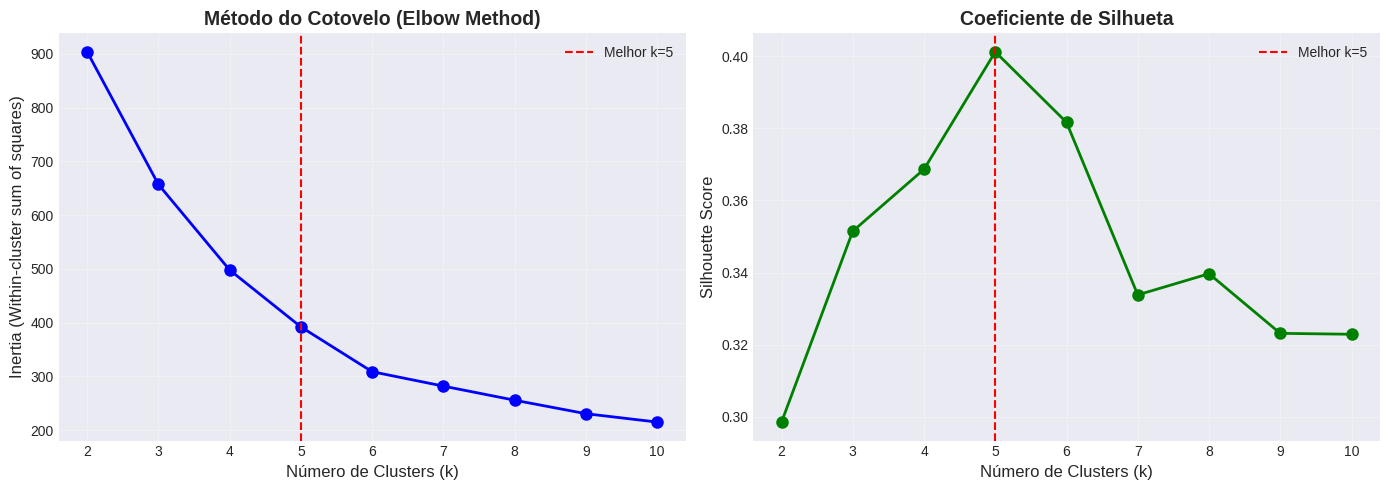

In [9]:
# Visualização dos resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico do Elbow Method
ax1.plot(range_k, inertias, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=best_k, color='r', linestyle='--', label=f'Melhor k={best_k}')
ax1.set_xlabel('Número de Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
ax1.set_title('Método do Cotovelo (Elbow Method)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Gráfico do Silhouette Score
ax2.plot(range_k, silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.axvline(x=best_k, color='r', linestyle='--', label=f'Melhor k={best_k}')
ax2.set_xlabel('Número de Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Coeficiente de Silhueta', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()


## 7. Treinamento do Modelo K-Means

Vamos treinar o modelo com o número ótimo de clusters identificado.


In [10]:
# Treinar modelo K-Means com melhor k
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# Adicionar clusters ao dataframe
df_semanal_clustered = df_semanal.loc[X.index].copy()
df_semanal_clustered['cluster'] = clusters

print(f"✅ Modelo K-Means treinado com {best_k} clusters!")
print(f"\n📊 Distribuição dos clusters:")
print(df_semanal_clustered['cluster'].value_counts().sort_index())
print(f"\n📈 Silhouette Score final: {silhouette_score(X_scaled, clusters):.3f}")


✅ Modelo K-Means treinado com 5 clusters!

📊 Distribuição dos clusters:
cluster
0     22
1    101
2     97
3     21
4     21
Name: count, dtype: int64

📈 Silhouette Score final: 0.401


## 8. Análise dos Clusters

Vamos analisar as características de cada cluster para entender os padrões climáticos identificados.


In [11]:
# Estatísticas por cluster
print("📊 Características dos Clusters:\n")
cluster_stats = df_semanal_clustered.groupby('cluster')[features_clustering].agg(['mean', 'std'])
print(cluster_stats)

# Análise mais detalhada
print("\n" + "="*80)
print("📈 Resumo por Cluster:")
print("="*80)

for cluster_id in sorted(df_semanal_clustered['cluster'].unique()):
    cluster_data = df_semanal_clustered[df_semanal_clustered['cluster'] == cluster_id]
    print(f"\n🔵 Cluster {cluster_id} ({len(cluster_data)} semanas - {len(cluster_data)/len(df_semanal_clustered)*100:.1f}%):")
    
    for feature in features_clustering:
        mean_val = cluster_data[feature].mean()
        print(f"   ➤ {feature}: {mean_val:.2f}")
    
    # Período do cluster
    print(f"   ➤ Período: {cluster_data['data_semana'].min().strftime('%Y-%m-%d')} até {cluster_data['data_semana'].max().strftime('%Y-%m-%d')}")


📊 Características dos Clusters:

           temp_ar              umidade              radiacao             \
              mean       std       mean       std        mean        std   
cluster                                                                    
0        22.035575  0.599786  78.758004  5.797575  392.384881  68.655889   
1        25.752391  0.716916  64.289854  5.737861  763.306451  53.257717   
2        23.216338  1.189022  73.912763  3.898864  640.451426  78.853355   
3        23.109543  0.586442  60.540776  1.650922  380.839897  66.091187   
4        27.061699  0.996081  60.801350  4.814893  690.319973  81.565935   

        vento_vel               pressao            
             mean       std        mean       std  
cluster                                            
0        1.226101  0.565110  947.262684  1.409925  
1        3.046341  0.474203  947.365349  1.366341  
2        2.826815  0.360262  951.008539  3.293246  
3        2.726478  0.279766  950.403002  1.725

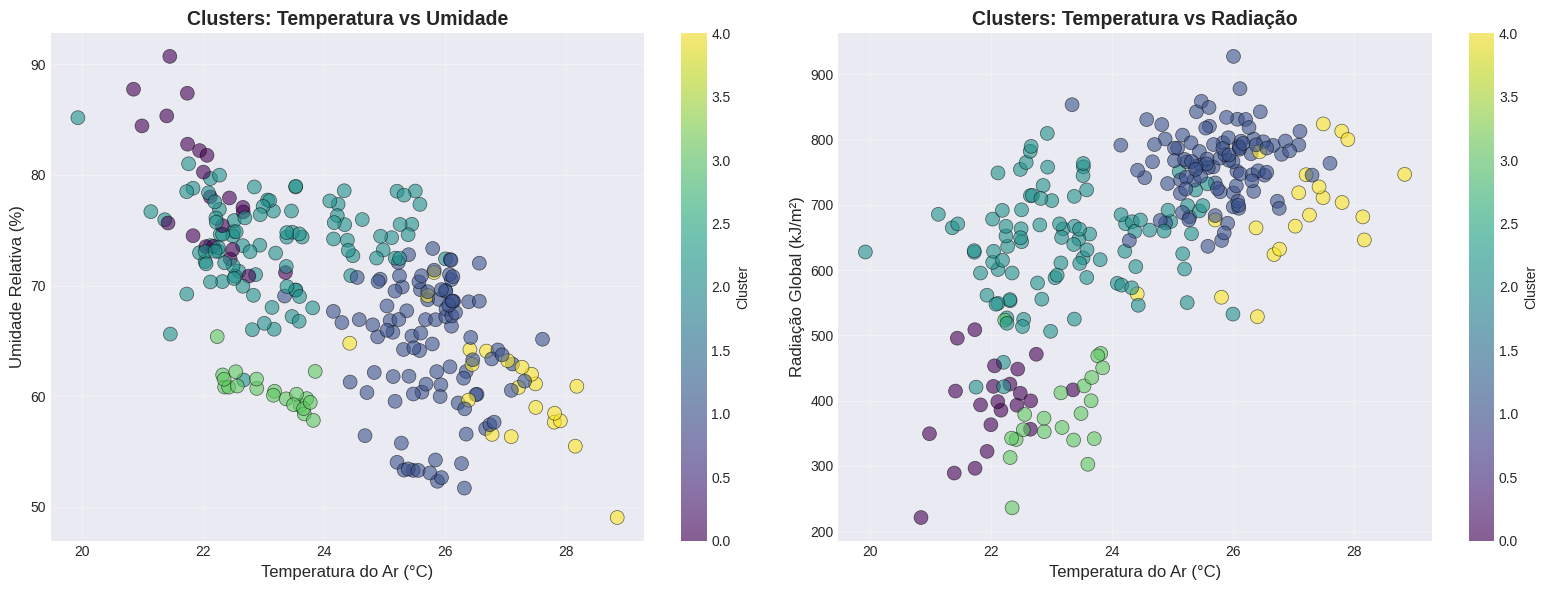

In [12]:
# Visualização dos clusters
if len(features_clustering) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico 1: Temperatura vs Umidade
    scatter1 = axes[0].scatter(
        df_semanal_clustered['temp_ar'],
        df_semanal_clustered['umidade'],
        c=df_semanal_clustered['cluster'],
        cmap='viridis',
        s=100,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )
    axes[0].set_xlabel('Temperatura do Ar (°C)', fontsize=12)
    axes[0].set_ylabel('Umidade Relativa (%)', fontsize=12)
    axes[0].set_title('Clusters: Temperatura vs Umidade', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0], label='Cluster')
    
    # Gráfico 2: Se tiver radiação, mostrar temperatura vs radiação
    if 'radiacao' in features_clustering:
        scatter2 = axes[1].scatter(
            df_semanal_clustered['temp_ar'],
            df_semanal_clustered['radiacao'],
            c=df_semanal_clustered['cluster'],
            cmap='viridis',
            s=100,
            alpha=0.6,
            edgecolors='black',
            linewidth=0.5
        )
        axes[1].set_xlabel('Temperatura do Ar (°C)', fontsize=12)
        axes[1].set_ylabel('Radiação Global (kJ/m²)', fontsize=12)
        axes[1].set_title('Clusters: Temperatura vs Radiação', fontsize=14, fontweight='bold')
        plt.colorbar(scatter2, ax=axes[1], label='Cluster')
    else:
        # Se não tiver radiação, mostrar vento vs pressão
        scatter2 = axes[1].scatter(
            df_semanal_clustered['vento_vel'],
            df_semanal_clustered['pressao'],
            c=df_semanal_clustered['cluster'],
            cmap='viridis',
            s=100,
            alpha=0.6,
            edgecolors='black',
            linewidth=0.5
        )
        axes[1].set_xlabel('Velocidade do Vento (m/s)', fontsize=12)
        axes[1].set_ylabel('Pressão Atmosférica (mB)', fontsize=12)
        axes[1].set_title('Clusters: Vento vs Pressão', fontsize=14, fontweight='bold')
        plt.colorbar(scatter2, ax=axes[1], label='Cluster')
    
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## 9. Registro do Modelo no MLFlow

Vamos registrar o modelo K-Means e os resultados no MLFlow para versionamento e rastreabilidade.


In [13]:
# Configurar variável de ambiente para evitar conflito de protobuf
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

# Tentar importar mlflow, se não estiver instalado, tentar instalar
try:
    import mlflow
    import mlflow.sklearn
except ImportError:
    print("⚠️  MLFlow não encontrado. Tentando instalar...")
    import sys
    import subprocess
    # Instalar protobuf compatível primeiro
    subprocess.check_call([sys.executable, "-m", "pip", "install", "protobuf<4.0"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "mlflow"])
    import mlflow
    import mlflow.sklearn
    print("✅ MLFlow instalado com sucesso!")
except Exception as e:
    if "protobuf" in str(e).lower() or "Protocol" in str(e):
        print("⚠️  Erro de compatibilidade do protobuf detectado.")
        print("   Tentando corrigir...")
        import sys
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "protobuf<4.0"])
        # Tentar importar novamente
        import mlflow
        import mlflow.sklearn
        print("✅ Problema corrigido!")
    else:
        raise

from datetime import datetime

# Configurar MLFlow
# Tentar diferentes URLs dependendo do ambiente (container vs host)
import socket
import requests

# Lista de URLs possíveis para o MLFlow
# Priorizar mlflow:5000 que funciona quando containers estão na mesma rede
possible_uris = [
    "http://mlflow:5000",     # Se rodando no mesmo docker network (PRIORIDADE)
    "http://localhost:5000",  # Se rodando no host
    "http://host.docker.internal:5000",  # Windows/Mac Docker Desktop
    "http://172.17.0.1:5000",  # Gateway padrão do Docker
]

MLFLOW_TRACKING_URI = None

# Testar qual URL funciona
print("🔍 Testando conexão com MLFlow...")
for uri in possible_uris:
    try:
        # Testar se o servidor responde
        response = requests.get(f"{uri}/health", timeout=2)
        if response.status_code == 200:
            MLFLOW_TRACKING_URI = uri
            print(f"✅ MLFlow encontrado em: {uri}")
            break
    except Exception as e:
        print(f"   ❌ {uri}: {str(e)[:50]}...")
        continue

if MLFLOW_TRACKING_URI is None:
    print("⚠️  Não foi possível conectar ao MLFlow automaticamente.")
    print("   Tentando usar http://mlflow:5000 como padrão...")
    MLFLOW_TRACKING_URI = "http://mlflow:5000"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"🔗 Configurado para usar: {MLFLOW_TRACKING_URI}")

# Verificar se a conexão está funcionando
try:
    print("🔍 Verificando conexão com MLFlow...")
    client = mlflow.tracking.MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
    experiments = client.search_experiments()
    print(f"✅ Conexão OK! Encontrados {len(experiments)} experimentos existentes.")
except Exception as e:
    print(f"⚠️  Aviso ao verificar conexão: {e}")
    print("   Continuando mesmo assim...")

# Criar experimento com timeout
experiment_name = "K-Means_Climatico_INMET"
try:
    print(f"📝 Criando/buscando experimento '{experiment_name}'...")
    print("   (Isso pode levar alguns segundos na primeira vez)...")
    
    # Tentar buscar experimento existente
    experiment = None
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        print(f"   ➤ Busca concluída")
    except Exception as e:
        print(f"   ⚠️  Erro ao buscar experimento: {e}")
        experiment = None
    
    if experiment is None:
        print(f"   ➤ Criando novo experimento...")
        experiment_id = mlflow.create_experiment(experiment_name)
        print(f"✅ Experimento '{experiment_name}' criado! (ID: {experiment_id})")
    else:
        experiment_id = experiment.experiment_id
        print(f"✅ Experimento '{experiment_name}' já existe! (ID: {experiment_id})")
    
    print(f"   ➤ Configurando experimento ativo...")
    mlflow.set_experiment(experiment_name)
    print("✅ Experimento configurado!")
except Exception as e:
    print(f"❌ Erro ao configurar experimento: {e}")
    print(f"   Tipo do erro: {type(e).__name__}")
    import traceback
    print(f"   Detalhes: {traceback.format_exc()}")
    raise


🔍 Testando conexão com MLFlow...
✅ MLFlow encontrado em: http://mlflow:5000
🔗 Configurado para usar: http://mlflow:5000
🔍 Verificando conexão com MLFlow...
✅ Conexão OK! Encontrados 2 experimentos existentes.
📝 Criando/buscando experimento 'K-Means_Climatico_INMET'...
   (Isso pode levar alguns segundos na primeira vez)...
   ➤ Busca concluída
✅ Experimento 'K-Means_Climatico_INMET' já existe! (ID: 1)
   ➤ Configurando experimento ativo...
✅ Experimento configurado!


In [14]:
# Iniciar run do MLFlow
with mlflow.start_run(run_name=f"KMeans_k{best_k}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
    
    # Inicializar flag de modelos salvos
    modelos_salvos = False
    
    # Logar parâmetros
    mlflow.log_param("n_clusters", best_k)
    mlflow.log_param("features", ", ".join(features_clustering))
    mlflow.log_param("n_samples", len(X_scaled))
    mlflow.log_param("random_state", 42)
    
    # Logar métricas
    mlflow.log_metric("silhouette_score", silhouette_score(X_scaled, clusters))
    mlflow.log_metric("inertia", kmeans_final.inertia_)
    
    # Logar distribuição dos clusters
    cluster_counts = df_semanal_clustered['cluster'].value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        mlflow.log_metric(f"cluster_{cluster_id}_size", count)
        mlflow.log_metric(f"cluster_{cluster_id}_percentage", count/len(df_semanal_clustered)*100)
    
    # Logar estatísticas por cluster
    for cluster_id in sorted(df_semanal_clustered['cluster'].unique()):
        cluster_data = df_semanal_clustered[df_semanal_clustered['cluster'] == cluster_id]
        for feature in features_clustering:
            mlflow.log_metric(f"cluster_{cluster_id}_{feature}_mean", cluster_data[feature].mean())
    
    # Salvar modelo (tentar várias abordagens)
    # Método 1: Tentar salvar usando artifact_path (salvar localmente primeiro)
    try:
        import pickle
        import tempfile
        import os
        
        # Criar diretório temporário local
        temp_dir = BASE_PROC / "temp_models"
        temp_dir.mkdir(exist_ok=True)
        
        # Salvar KMeans localmente
        kmeans_path = temp_dir / "kmeans_model.pkl"
        with open(kmeans_path, 'wb') as f:
            pickle.dump(kmeans_final, f)
        
        # Salvar Scaler localmente
        scaler_path = temp_dir / "scaler.pkl"
        with open(scaler_path, 'wb') as f:
            pickle.dump(scaler, f)
        
        # Fazer upload para MLFlow
        mlflow.log_artifact(str(kmeans_path), "models")
        mlflow.log_artifact(str(scaler_path), "models")
        
        # Limpar arquivos temporários
        os.unlink(kmeans_path)
        os.unlink(scaler_path)
        temp_dir.rmdir()
        
        modelos_salvos = True
        print("   ✅ Modelos salvos como artifacts pickle")
        
    except Exception as e1:
        print(f"   ⚠️  Erro ao salvar modelos (método 1): {str(e1)[:100]}")
        
        # Método 2: Tentar usar a API do MLFlow diretamente (pode falhar por versão)
        try:
            mlflow.sklearn.log_model(kmeans_final, artifact_path="kmeans_model")
            mlflow.sklearn.log_model(scaler, artifact_path="scaler")
            modelos_salvos = True
            print("   ✅ Modelos salvos usando API MLFlow")
        except Exception as e2:
            print(f"   ⚠️  Erro ao salvar modelos (método 2): {str(e2)[:100]}")
            print("   ℹ️  Modelos não foram salvos no MLFlow, mas todas as métricas foram registradas!")
            print("   ℹ️  Os modelos podem ser salvos localmente se necessário.")
    
    if not modelos_salvos:
        # Salvar localmente como backup
        try:
            import pickle
            backup_dir = BASE_PROC / "modelos_backup"
            backup_dir.mkdir(exist_ok=True)
            
            with open(backup_dir / "kmeans_model.pkl", 'wb') as f:
                pickle.dump(kmeans_final, f)
            with open(backup_dir / "scaler.pkl", 'wb') as f:
                pickle.dump(scaler, f)
            print(f"   💾 Modelos salvos localmente em: {backup_dir}")
        except Exception as e3:
            print(f"   ⚠️  Não foi possível salvar modelos localmente: {e3}")
    
    # Salvar dados agregados com clusters
    output_path = BASE_PROC / "dados_semanais_clustered.csv"
    df_semanal_clustered.to_csv(output_path)
    
    # Tentar salvar como artifact (pode falhar por permissão)
    try:
        mlflow.log_artifact(str(output_path), "data")
        print("   ✅ Dados salvos como artifact no MLFlow")
    except PermissionError as e:
        print(f"   ⚠️  Não foi possível salvar dados como artifact (permissão): {str(e)[:100]}")
        print("   ℹ️  Dados salvos localmente, mas não foram enviados ao MLFlow")
    except Exception as e:
        print(f"   ⚠️  Erro ao salvar artifact: {str(e)[:100]}")
        print("   ℹ️  Dados salvos localmente")
    
    print("\n✅ Modelo registrado no MLFlow com sucesso!")
    print(f"   ➤ Run ID: {mlflow.active_run().info.run_id}")
    print(f"   ➤ Experimento: {experiment_name}")
    print(f"   ➤ Dados salvos localmente em: {output_path}")
    print("\n📊 Resumo:")
    print("   ✅ Parâmetros registrados")
    print("   ✅ Métricas registradas")
    if modelos_salvos:
        print("   ✅ Modelos registrados")
    else:
        print("   ⚠️  Modelos salvos apenas localmente (problema de permissão no MLFlow)")
    print("   ✅ Dados agregados salvos localmente")


2025/12/04 00:05:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ⚠️  Erro ao salvar modelos (método 1): [Errno 13] Permission denied: '/mlflow'
   ⚠️  Erro ao salvar modelos (método 2): API request to endpoint /api/2.0/mlflow/logged-models failed with error code 404 != 200. Response bo
   ℹ️  Modelos não foram salvos no MLFlow, mas todas as métricas foram registradas!
   ℹ️  Os modelos podem ser salvos localmente se necessário.
   💾 Modelos salvos localmente em: /home/jovyan/data/processed/modelos_backup
   ⚠️  Não foi possível salvar dados como artifact (permissão): [Errno 13] Permission denied: '/mlflow'
   ℹ️  Dados salvos localmente, mas não foram enviados ao MLFlow

✅ Modelo registrado no MLFlow com sucesso!
   ➤ Run ID: 9834cb7cb8b24eaf8e4ed4428c3f0d83
   ➤ Experimento: K-Means_Climatico_INMET
   ➤ Dados salvos localmente em: /home/jovyan/data/processed/dados_semanais_clustered.csv

📊 Resumo:
   ✅ Parâmetros registrados
   ✅ Métricas registradas
   ⚠️  Modelos salvos apenas localmente (problema de permissão no MLFlow)
   ✅ Dados agregados s

## 10. Salvamento dos Resultados

Vamos salvar os resultados finais para uso em dashboards e análises posteriores.


In [15]:
# Salvar resultados finais
output_file = BASE_PROC / "dados_semanais_clustered.csv"
df_semanal_clustered.to_csv(output_file, index=False)

print(f"✅ Resultados salvos em: {output_file}")
print(f"\n📊 Resumo Final:")
print(f"   ➤ Total de semanas analisadas: {len(df_semanal_clustered)}")
print(f"   ➤ Número de clusters: {best_k}")
print(f"   ➤ Silhouette Score: {silhouette_score(X_scaled, clusters):.3f}")
print(f"\n🎉 Modelagem K-Means concluída com sucesso!")


✅ Resultados salvos em: /home/jovyan/data/processed/dados_semanais_clustered.csv

📊 Resumo Final:
   ➤ Total de semanas analisadas: 262
   ➤ Número de clusters: 5
   ➤ Silhouette Score: 0.401

🎉 Modelagem K-Means concluída com sucesso!
